# Graph Linear Automaton

### Problem description

We define a graph of "values" as $G = (V, E)$, where $V$ is the set of vertices $v_i \in V$, and $E$ is a set of unordered pairs $\{u, v\}$, $u,v \in V$. Each vertex has a state value $x_i \in (0, 1)$. We can discretize the values in time domain by introducing $t \in 1, ..., T$ and update the value in each cell with using logistic formula:

$$
    x_i^{t+1} = m A_i^t (1 - A_i^t),
$$

where:
- $m$ is some growth parameter from the interval $[2, 4]$.
- $A_i^t$ is the average of neighbor values of $i$-th node and time $t$.

### Graph generation

For big graphs (more than 10k vertices) its better to store the graph in the form of adjacency list. First we can focus on generating the graphs. Lets generate few types of graphs:
- 2D grid (wrapping edges)
- Ring with additional k-neighbors connections
- Hypercube
- Random regular graph with given degree

We can start by generating first three types of graphs.

In [1]:
import numpy as np

from graph_generator import RegularGraphGenerator
from layout_generator import LayoutGenerator, plot_graph

graphs = {
    "2d-grid":    np.array(RegularGraphGenerator.generate_toroidal_grid(100, 100)),
    "ring5":      np.array(RegularGraphGenerator.generate_ring_regular(10000, 5)),
    "hypercube":  np.array(RegularGraphGenerator.generate_hypercube(13)),
}

coords = {
    "2d-grid":    LayoutGenerator.layout_grid_2d(100, 100),
    "ring5":      LayoutGenerator.layout_circular(10000),
    "hypercube":  LayoutGenerator.layout_random(len(graphs["hypercube"]))
}

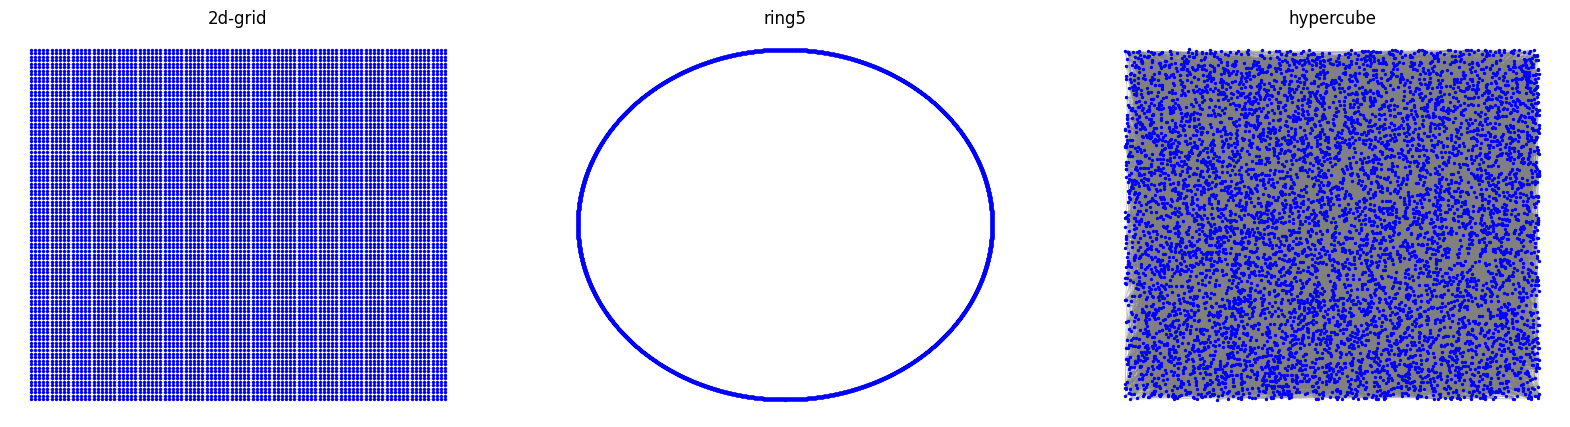

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(graphs), figsize=(16, 5))
for i, (name, graph) in enumerate(graphs.items()):
    plot_graph(ax[i], graph, coords=coords[name], title=name)

### Simulation

We will run the simulations where each state value is initialized from uniform distribution $x_i \sim \mathcal{U}(0, 1)$.

In [ ]:
from simulation import simulate
from gifs import make_gif

for i, (name, graph) in enumerate(graphs.items()):
    simulate(
        adj=graph,
        coords=coords[name],
        steps=2000,
        m=4,
        plot_every=20,
        values_init="uniform",
        title=f"Graph type {name}",
        output_folder=f"simulations/1/{name}",
        verbose=True
    )
    make_gif(f"simulations/1/{name}", "figures/gifs/1", f"{name}.gif")

The result of those simulations can be seen below:

![](figures/gifs/1/2d-grid.gif)
![](figures/gifs/1/ring5.gif)
![](figures/gifs/1/hypercube.gif)

Now lets experiment with random regular graphs with degree $k$.

In [ ]:
for k in range(3, 8):
    random_adj = np.array(RegularGraphGenerator.generate_random_regular_connected(10000, k))
    random_coords = LayoutGenerator.layout_random(10000)
    name = f"random{k}"
    simulate(
        adj=random_adj,
        coords=random_coords,
        steps=2000,
        m=4,
        plot_every=20,
        values_init="uniform",
        title=f"Random regular graph k={k}",
        output_folder=f"simulations/2/{name}",
        verbose=True
    )
    make_gif(f"simulations/2/{name}", "figures/gifs/2", f"{name}.gif")


![](figures/gifs/2/random3.gif)
![](figures/gifs/2/random4.gif)
![](figures/gifs/2/random5.gif)
![](figures/gifs/2/random6.gif)
![](figures/gifs/2/random7.gif)

### Bifurcation

Lets try to simulate the bifuraction plot for some random graph. I will use much smaller random regular graph $N = 500$ with degree $k = 5$. I will perform 100 steps of iteration for each value of $m$ then record the the next 100 values from the simulation, also aggregating along 10 simulation runs.

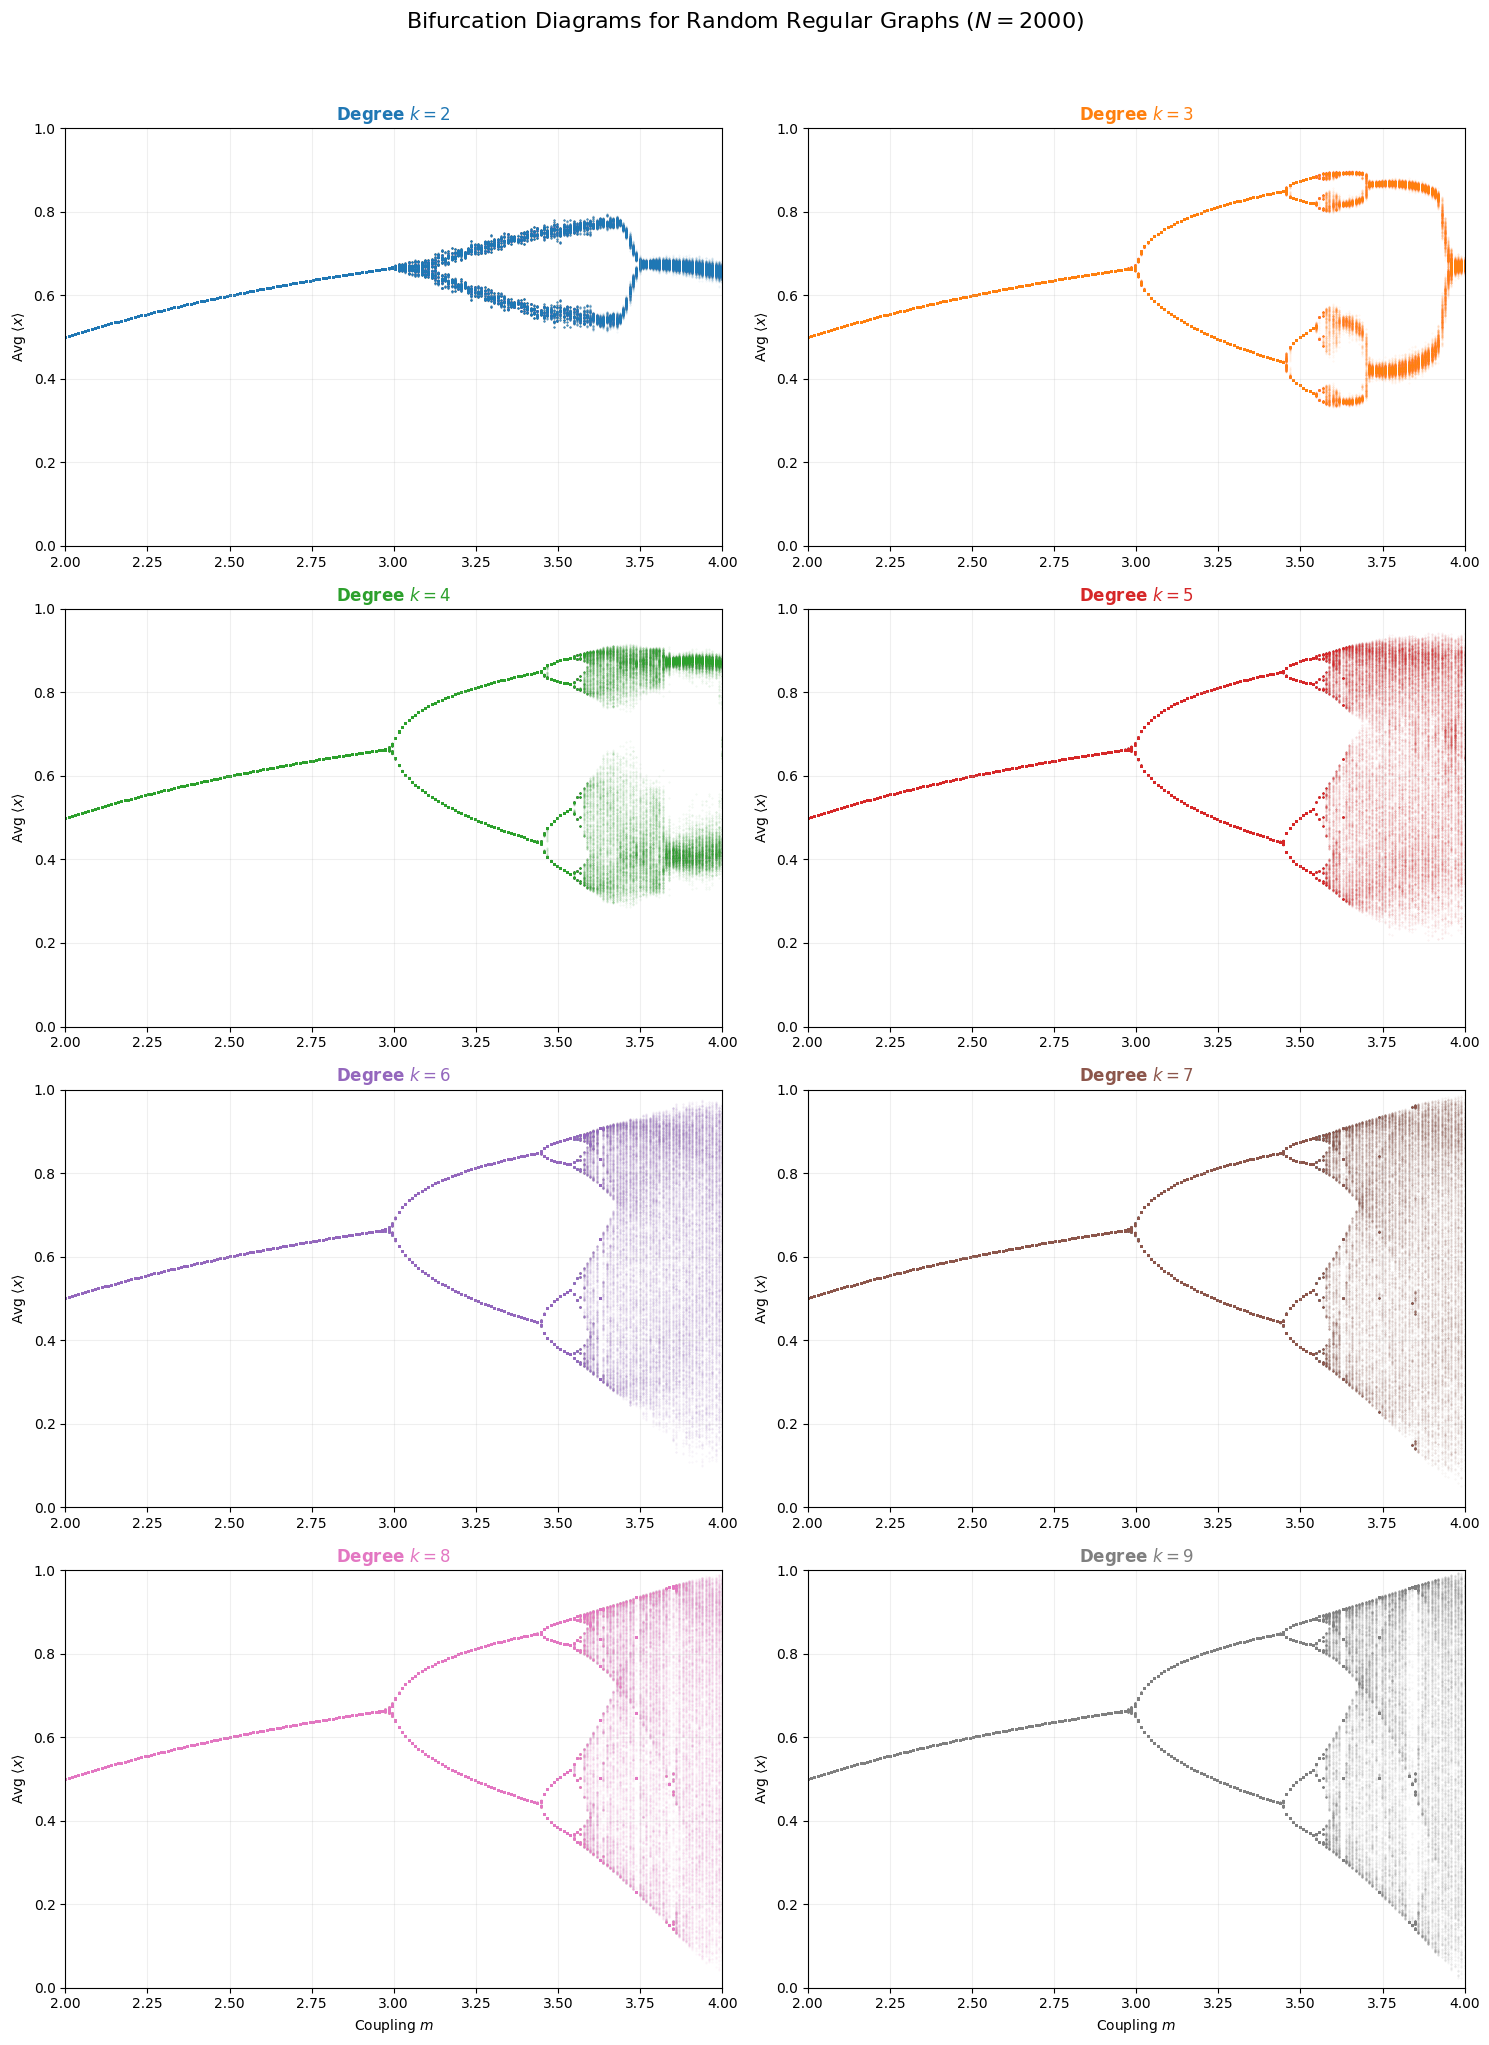

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from simulation import simulate

m_values = np.linspace(2.0, 4.0, 200)
steps_burn_in = 100       
steps_aggregate = 100    
repeats_per_m = 10    
N = 2000

k_values = range(2, 10) 

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes_flat = axes.flatten()
cmap = plt.get_cmap('tab10')

for i, (k, ax) in enumerate(zip(k_values, axes_flat)):
    
    random_adj = np.array(RegularGraphGenerator.generate_random_regular_connected(N, k))
    random_coords = LayoutGenerator.layout_random(N)

    plot_m = []
    plot_x = []
    
    current_color = cmap(i)

    for m in tqdm(m_values, desc=f"Simulating k={k}", leave=False):
        for _ in range(repeats_per_m):
            results = simulate(
                adj=random_adj,
                coords=random_coords,
                steps=steps_burn_in,
                m=m,
                plot_every=0,
                values_init="uniform",
                title="",
                output_folder="temp_void",
                linearize=0,
                aggregate=steps_aggregate
            )
            
            plot_x.extend(results)
            plot_m.extend([m] * len(results))

    ax.scatter(plot_m, plot_x, s=0.1, color=current_color, alpha=0.1)
    ax.set_title(f"Degree $k={k}$", fontsize=12, fontweight='bold', color=current_color)
    ax.set_ylabel("Avg $\\langle x \\rangle$")
    ax.set_xlim(2.0, 4.0)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.2)
    
    if i >= 6: 
        ax.set_xlabel("Coupling $m$")

fig.suptitle(f"Bifurcation Diagrams for Random Regular Graphs ($N={N}$)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()